# Digital Twin

[Link to Article](https://towardsdatascience.com/supply-chain-sustainability-reporting-with-python-161c1f63f267)

To create a digital twin of a supply chain using Python, you first need to define the various components and processes that make up the supply chain.

Next, you would need to collect data on the various components and processes of the supply chain, such as

- Locations and **capacities of warehouses**
- Routes and capacities of **transportation networks**
- Production rates of production facilities
- Customer and store demand

## Simulation blocks

---

Once you have the data on the supply chain components and processes, you can use Python to create algorithms and simulations that replicate the supply chain's behaviour.

- Determine the most efficient routes*(output)* to **deliver stores** using replenishment orders *(input)* coming from the store model
- Improve the picking processes *(output)* in your warehouse to prepare store replenishment orders *(input)*
- Schedule your production (output) based on demand forecasts built with the stores’ sales historical data (input)

### Warehouse

In [8]:
# Define a Warehouse class to represent a warehouse
class Warehouse:
    def __init__(self, location, capacity):
        self.location = location
        self.capacity = capacity
        self.inventory = {}
        
    def add_inventory(self, item, quantity):
        if item in self.inventory:
            # either add to inventory or update quantity
            self.inventory[item] += quantity
        else:
            self.inventory[item] = quantity
            
    def remove_inventory(self, item, quantity):
        # check if item is in inventory and if there is enough quantity to remove
        if item in self.inventory and self.inventory[item] >= quantity:
            self.inventory[item] -= quantity
        else:
            print("Error: Not enough inventory to fulfill order.")


In [9]:

# Create a warehouse at location "New York" with a capacity of 100
warehouse = Warehouse("New York", 100)

# Add 10 units of item "A" to the warehouse's inventory
warehouse.add_inventory("A", 10)

# Remove 5 units of item "A" from the warehouse's inventory
warehouse.remove_inventory("A", 5)

print(f'Warehouse inventory: {warehouse.inventory}')

Warehouse inventory: {'A': 5}


```{note}
if your final goal is to use the insights this model provides, ensure that all the stakeholders validate the assumptions and parameters used to build it.
```

### Trucks

In [11]:
# Define a Truck class to represent a truck
class Truck:
    def __init__(self, location, capacity):
        self.location = location
        self.capacity = capacity
        self.cargo = {}
        
    def load_cargo(self, item, quantity):
        # check if there is enough capacity to load cargo
        if sum(self.cargo.values()) + quantity <= self.capacity:
            # either add to cargo or update quantity
            if item in self.cargo:
                self.cargo[item] += quantity
            else:
                self.cargo[item] = quantity
        else:
            print("Error: Not enough capacity to load cargo.")
            
    def unload_cargo(self, item, quantity):
        # check if item is in cargo and if there is enough quantity to unload
        if item in self.cargo and self.cargo[item] >= quantity:
            self.cargo[item] -= quantity
        else:
            print("Error: Cargo not found.")
            
    def move_to(self, location):
        self.location = location

In [13]:
# Create a truck at location "Paris" with a capacity of 100
truck = Truck("Paris", 100)

# Load 50 units of item "A" onto the truck
truck.load_cargo("A", 50)

# Move the truck to location "Lille"
truck.move_to("Lille")

# Unload 25 units of item "A" from the truck
truck.unload_cargo("A", 25)

print(f'Truck cargo: {truck.cargo}')

Truck cargo: {'A': 25}


### Store

In [17]:
# Define a Store class to represent a store
class Store:
    def __init__(self, location, inventory):
        self.location = location
        self.inventory = inventory
        
    def place_order(self, item, quantity):
        if item in self.inventory and self.inventory[item] >= quantity:
            self.inventory[item] -= quantity
            print("Order fulfilled.")
        else:
            print("Error: Not enough inventory to fulfill order.")

In [18]:
# Create a store at location "New York" with 10 units of item "A" in inventory
store = Store("New York", {"A": 10})

# Place an order for 5 units of item "A"
store.place_order("A", 5)

print(f'Store inventory: {store.inventory}')

Order fulfilled.
Store inventory: {'A': 5}


## Simulation

In [38]:
import random
import matplotlib.pyplot as plt

class SupplyChainSimulation:
    def __init__(self, warehouses, trucks, stores):
        self.warehouses = warehouses
        self.trucks = trucks
        self.stores = stores
        self.time_step = 0
        
        # Demand log: list of dicts, each with time_step, store, item, quantity
        self.demand_log = []
        # Inventory log: list of dicts, each with time_step, warehouse_location, item, quantity
        self.inventory_log = []

    def run_step(self):
        print(f"--- Time Step {self.time_step} ---")

        items = ["WidgetA", "WidgetB", "WidgetC"]  # possible SKUs
        for store in self.stores:
            item_to_order = random.choice(items)
            quantity_to_order = random.randint(5, 15)
            print(f"Store at {store.location} requests {quantity_to_order} units of {item_to_order}.")

            # LOG the demand
            self.demand_log.append({
                "time_step": self.time_step,
                "store_location": store.location,
                "item": item_to_order,
                "quantity": quantity_to_order
            })

            # We'll just use the first truck & first warehouse for demonstration
            truck = self.trucks[0]
            warehouse = self.warehouses[0]

            # Move truck to warehouse
            if truck.location != warehouse.location:
                truck.move_to(warehouse.location)

            # Check warehouse inventory & load cargo
            if item_to_order in warehouse.inventory and warehouse.inventory[item_to_order] >= quantity_to_order:
                print(f"Loading {quantity_to_order} of {item_to_order} onto truck.")
                warehouse.remove_inventory(item_to_order, quantity_to_order)
                truck.load_cargo(item_to_order, quantity_to_order)
            else:
                print(f"Warehouse at {warehouse.location} does not have enough {item_to_order} in stock.\n")
                continue  # skip delivery if not enough stock

            # Deliver to store
            truck.move_to(store.location)
            truck.unload_cargo(item_to_order, quantity_to_order)

            # Add to store’s inventory
            store.inventory[item_to_order] = store.inventory.get(item_to_order, 0) + quantity_to_order
            print(f"Delivered {quantity_to_order} {item_to_order} to {store.location}.\n")
            
        # After processing all stores in this time step, log the warehouse inventory
        for warehouse in self.warehouses:
            for item, qty in warehouse.inventory.items():
                self.inventory_log.append({
                    "time_step": self.time_step,
                    "warehouse_location": warehouse.location,
                    "item": item,
                    "quantity": qty
                })

        self.time_step += 1

    def run_simulation(self, steps=5):
        for _ in range(steps):
            self.run_step()
            print()

    def plot_demand_and_inventory(self, 
                                  store_location=None, 
                                  warehouse_location=None, 
                                  item=None):
        """
        Plot both Demand (for a store) and Inventory (for a warehouse) in the same figure 
        as separate lines, filtered by location/item if provided.
        """
        # ----------------------
        # 1) Aggregate DEMAND
        # ----------------------
        filtered_demand = [
            entry for entry in self.demand_log
            if (store_location is None or entry["store_location"] == store_location)
            and (item is None or entry["item"] == item)
        ]
        demand_by_time = {}
        for entry in filtered_demand:
            t = entry["time_step"]
            q = entry["quantity"]
            demand_by_time[t] = demand_by_time.get(t, 0) + q  # sum if multiple orders in same step

        # ----------------------
        # 2) Aggregate INVENTORY
        # ----------------------
        filtered_inventory = [
            row for row in self.inventory_log
            if (warehouse_location is None or row["warehouse_location"] == warehouse_location)
            and (item is None or row["item"] == item)
        ]
        inventory_by_time = {}
        for row in filtered_inventory:
            t = row["time_step"]
            q = row["quantity"]
            # If multiple items in the same step, sum them or pick a strategy
            inventory_by_time[t] = q  # or inventory_by_time.get(t, 0) + q

        # ----------------------
        # 3) Merge time steps
        # ----------------------
        all_time_steps = set(demand_by_time.keys()).union(set(inventory_by_time.keys()))
        time_steps = sorted(all_time_steps)

        demand_values = [demand_by_time.get(t, 0) for t in time_steps]
        inventory_values = [inventory_by_time.get(t, 0) for t in time_steps]

        # ----------------------
        # 4) Plot both lines
        # ----------------------
        plt.figure(figsize=(8,5))
        plt.plot(time_steps, demand_values, marker='o', label='Demand')
        plt.plot(time_steps, inventory_values, marker='s', label='Inventory')

        title_str = "Demand & Inventory Over Time"
        if store_location:
            title_str += f" (Store: {store_location})"
        if warehouse_location:
            title_str += f" (Warehouse: {warehouse_location})"
        if item:
            title_str += f" (Item: {item})"

        plt.title(title_str)
        plt.xlabel("Time Step")
        plt.ylabel("Quantity")
        plt.xticks(time_steps)
        plt.legend()
        plt.grid(True)
        plt.show()


--- Time Step 0 ---
Store at Store_1 requests 15 units of WidgetC.
Warehouse at Warehouse_1 does not have enough WidgetC in stock.

Store at Store_2 requests 15 units of WidgetA.
Loading 15 of WidgetA onto truck.
Delivered 15 WidgetA to Store_2.


--- Time Step 1 ---
Store at Store_1 requests 11 units of WidgetB.
Loading 11 of WidgetB onto truck.
Delivered 11 WidgetB to Store_1.

Store at Store_2 requests 6 units of WidgetA.
Loading 6 of WidgetA onto truck.
Delivered 6 WidgetA to Store_2.


--- Time Step 2 ---
Store at Store_1 requests 8 units of WidgetB.
Loading 8 of WidgetB onto truck.
Delivered 8 WidgetB to Store_1.

Store at Store_2 requests 6 units of WidgetA.
Loading 6 of WidgetA onto truck.
Delivered 6 WidgetA to Store_2.


--- Time Step 3 ---
Store at Store_1 requests 15 units of WidgetA.
Loading 15 of WidgetA onto truck.
Delivered 15 WidgetA to Store_1.

Store at Store_2 requests 13 units of WidgetA.
Loading 13 of WidgetA onto truck.
Delivered 13 WidgetA to Store_2.


--- Time

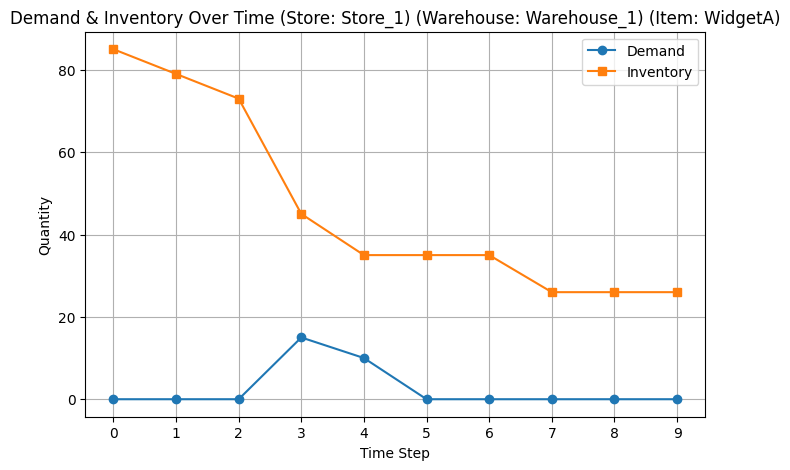

In [42]:
# Now let's instantiate everything and run a short simulation:
warehouse1 = Warehouse("Warehouse_1", capacity=1000)
# Pre-populate warehouse
warehouse1.add_inventory("WidgetA", 100)
warehouse1.add_inventory("WidgetB", 50)

truck1 = Truck(location="Garage", capacity=50)
store1 = Store(location="Store_1", inventory={"WidgetA": 10})
store2 = Store(location="Store_2", inventory={"WidgetB": 20})

# Create the simulation
sim = SupplyChainSimulation(
    warehouses=[warehouse1],
    trucks=[truck1],
    stores=[store1, store2]
)

# Run for 5 time steps
sim.run_simulation(steps=10)

# Plot Demand & Inventory together
# e.g. focusing on Warehouse_1's inventory and all demands from Store_1
sim.plot_demand_and_inventory(store_location="Store_1", warehouse_location="Warehouse_1", item="WidgetA")